# Preprocessing and Modelling

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
from prophet import Prophet
import cmdstanpy

## Load Data

In [6]:
data = pd.read_csv("../data/process/data.csv", index_col = 0)
data.index = pd.to_datetime(data.index)
data.head()

,Tesla,Nio,Rivian,Lucid Motors,Ford,General Motors,Interest Rate,CCI,Oil Prices,CPI
2021-11-10,355.983337,39.549999,100.730003,40.750000,15.992259,58.052616,0.163998,99.53249,81.340,5.921978
2021-11-11,354.503326,42.200001,122.989998,44.980000,16.149210,60.550247,0.163998,99.53249,81.590,5.921978
2021-11-12,344.473328,42.669998,129.949997,43.930000,16.107906,62.097797,0.163998,99.53249,80.790,5.921978
2021-11-15,337.796661,40.570000,149.360001,44.880001,16.405285,61.676624,0.163998,99.53249,80.880,5.921978
2021-11-16,351.576660,40.669998,172.009995,55.520000,16.347464,61.324028,0.163998,99.53249,80.556,5.921978


## Preprocessing

### Check for missing values

In [7]:
data.isna().sum()

Tesla             0
Nio               0
Rivian            0
Lucid Motors      0
Ford              0
General Motors    0
Interest Rate     0
CCI               0
Oil Prices        0
CPI               0
dtype: int64

## Feature Engineering

### Date Features

In [8]:
data["month"] = data.index.month
data["day"] = data.index.day
data["weekday"] = data.index.weekday + 1
data["year"] = data.index.year

### Lag Features

In [9]:
data["Date"] = data.index
data = data.reset_index(drop = True)
lag_features = ["Tesla", "Nio", "Rivian", "Lucid Motors", "Ford", "General Motors", "Interest Rate", "CCI", "Oil Prices", "CPI"]
window1 = 1
window2 = 4
window3 = 30

data_rolled_1 = data[lag_features].rolling(window = window1, min_periods = 0)
data_rolled_4 = data[lag_features].rolling(window = window2, min_periods = 0)
data_rolled_30 = data[lag_features].rolling(window = window3, min_periods = 0)

data_mean_1 = data_rolled_1.mean().shift(1).reset_index().astype(np.float32)
data_mean_4 = data_rolled_4.mean().shift(1).reset_index().astype(np.float32)
data_mean_30 = data_rolled_30.mean().shift(1).reset_index().astype(np.float32)

data_std_4 = data_rolled_4.std().shift(1).reset_index().astype(np.float32)
data_std_30 = data_rolled_30.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    data[f"{feature}_mean_lag{window1}"] = data_mean_1[feature]
    data[f"{feature}_mean_lag{window2}"] = data_mean_4[feature]
    data[f"{feature}_mean_lag{window3}"] = data_mean_30[feature]

    data[f"{feature}_std_lag{window2}"] = data_std_4[feature]
    data[f"{feature}_std_lag{window3}"] = data_std_30[feature]

data.fillna(data.mean(), inplace = True)

data.set_index("Date", drop = True, inplace = True)

data.head()

,Tesla,Nio,Rivian,Lucid Motors,Ford,General Motors,Interest Rate,CCI,Oil Prices,CPI,...,Oil Prices_mean_lag1,Oil Prices_mean_lag4,Oil Prices_mean_lag30,Oil Prices_std_lag4,Oil Prices_std_lag30,CPI_mean_lag1,CPI_mean_lag4,CPI_mean_lag30,CPI_std_lag4,CPI_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-10,355.983337,39.549999,100.730003,40.750000,15.992259,58.052616,0.163998,99.53249,81.340,5.921978,...,84.002167,84.002518,83.991913,1.676590,3.906139,5.554287,5.562372,5.628571,0.080226,0.538754
2021-11-11,354.503326,42.200001,122.989998,44.980000,16.149210,60.550247,0.163998,99.53249,81.590,5.921978,...,81.339996,81.339996,81.339996,1.676590,3.906139,5.921978,5.921978,5.921978,0.080226,0.538754
2021-11-12,344.473328,42.669998,129.949997,43.930000,16.107906,62.097797,0.163998,99.53249,80.790,5.921978,...,81.589996,81.464996,81.464996,0.176777,0.176777,5.921978,5.921978,5.921978,0.000000,0.000000
2021-11-15,337.796661,40.570000,149.360001,44.880001,16.405285,61.676624,0.163998,99.53249,80.880,5.921978,...,80.790001,81.239998,81.239998,0.409268,0.409268,5.921978,5.921978,5.921978,0.000000,0.000000
2021-11-16,351.576660,40.669998,172.009995,55.520000,16.347464,61.324028,0.163998,99.53249,80.556,5.921978,...,80.879997,81.150002,81.150002,0.379561,0.379561,5.921978,5.921978,5.921978,0.000000,0.000000


## Modelling

### Tesla ARIMA Model

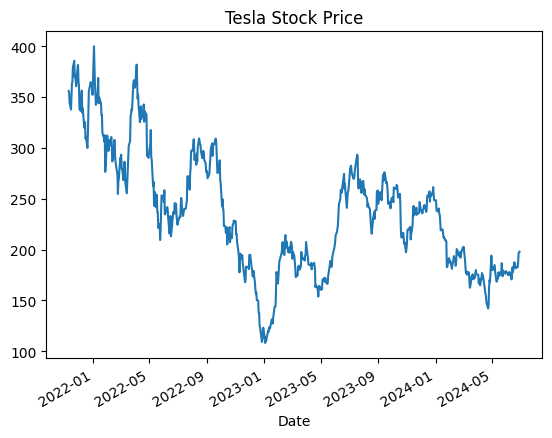

In [10]:
data["Tesla"].plot()
plt.title("Tesla Stock Price")
plt.show()

Test for Stationarity

In [11]:
tesla_adft = adfuller(data["Tesla"])
print(f"Test Statistic: {tesla_adft[0]}")
print(f"p-value: {tesla_adft[1]}")
if tesla_adft[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

Test Statistic: -2.7808457598001297
p-value: 0.06106233313852333
The time series is not stationary.


Transform the time series to make it stationary

In [12]:
tesla_adft = adfuller(data["Tesla"].diff().dropna())
print(f"Test Statistic: {tesla_adft[0]}")
print(f"p-value: {tesla_adft[1]}")
if tesla_adft[1] < 0.05:
    print("The time series (First Diff.) is stationary.")
else:
    print("The time series (First Diff.) is not stationary.")

Test Statistic: -7.5943052837340685
p-value: 2.4837502917329755e-11
The time series (First Diff.) is stationary.


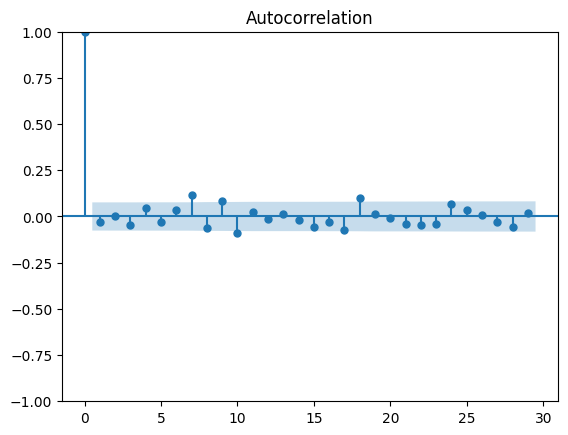

In [13]:
plot_acf(data["Tesla"].diff().dropna())
plt.show()

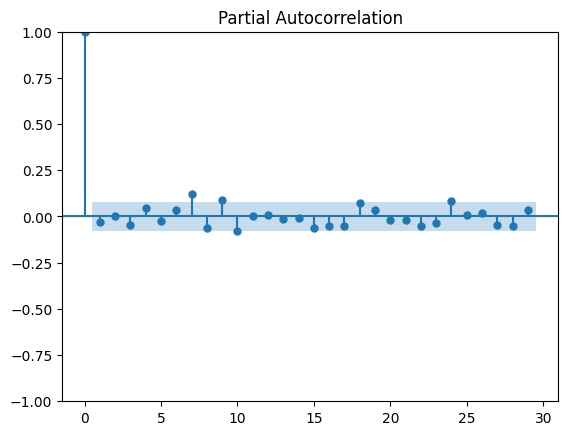

In [14]:
plot_pacf(data["Tesla"].diff().dropna())
plt.show()

In [15]:
tesla_pmdarima = auto_arima(data["Tesla"],
                            seasonal = True,
                            trace = True,
                            error_action = "ignore",
                            stepwise = True
                            )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4782.171, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4775.477, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4776.833, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4776.834, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4773.946, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4778.213, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.080 seconds


In [16]:
tesla_pmdarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  661
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2385.973
Date:                Sun, 01 Sep 2024   AIC                           4773.946
Time:                        20:44:45   BIC                           4778.438
Sample:                             0   HQIC                          4775.687
                                - 661                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        80.8322      2.990     27.034      0.000      74.972      86.693
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):               162.32
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Auto ARIMA + Exogenous Variables

In [17]:
data.columns

Index(['Tesla', 'Nio', 'Rivian', 'Lucid Motors', 'Ford', 'General Motors',
       'Interest Rate', 'CCI', 'Oil Prices', 'CPI', 'month', 'day', 'weekday',
       'year', 'Tesla_mean_lag1', 'Tesla_mean_lag4', 'Tesla_mean_lag30',
       'Tesla_std_lag4', 'Tesla_std_lag30', 'Nio_mean_lag1', 'Nio_mean_lag4',
       'Nio_mean_lag30', 'Nio_std_lag4', 'Nio_std_lag30', 'Rivian_mean_lag1',
       'Rivian_mean_lag4', 'Rivian_mean_lag30', 'Rivian_std_lag4',
       'Rivian_std_lag30', 'Lucid Motors_mean_lag1', 'Lucid Motors_mean_lag4',
       'Lucid Motors_mean_lag30', 'Lucid Motors_std_lag4',
       'Lucid Motors_std_lag30', 'Ford_mean_lag1', 'Ford_mean_lag4',
       'Ford_mean_lag30', 'Ford_std_lag4', 'Ford_std_lag30',
       'General Motors_mean_lag1', 'General Motors_mean_lag4',
       'General Motors_mean_lag30', 'General Motors_std_lag4',
       'General Motors_std_lag30', 'Interest Rate_mean_lag1',
       'Interest Rate_mean_lag4', 'Interest Rate_mean_lag30',
       'Interest Rate_std_lag4',

In [18]:
X = data.drop(columns = ["Tesla", "Nio", "Rivian", "Lucid Motors", "Ford", "General Motors", "Interest Rate", "CCI", "Oil Prices", "CPI"])
y = data["Tesla"]

tesla_arimax = auto_arima(y,
                          exogenous = X,
                          seasonal = True,
                          trace = True,
                          error_action = "ignore",
                          stepwise = True
                          )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4782.171, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4775.477, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4776.833, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4776.834, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4773.946, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4778.213, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.200 seconds


In [19]:
tesla_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  661
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2385.973
Date:                Sun, 01 Sep 2024   AIC                           4773.946
Time:                        20:44:47   BIC                           4778.438
Sample:                             0   HQIC                          4775.687
                                - 661                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        80.8322      2.990     27.034      0.000      74.972      86.693
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):               162.32
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ML Approach

In [20]:
data.index

DatetimeIndex(['2021-11-10', '2021-11-11', '2021-11-12', '2021-11-15',
               '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-22', '2021-11-23',
               ...
               '2024-06-14', '2024-06-17', '2024-06-18', '2024-06-20',
               '2024-06-21', '2024-06-24', '2024-06-25', '2024-06-26',
               '2024-06-27', '2024-06-28'],
              dtype='datetime64[ns]', name='Date', length=661, freq=None)

In [21]:
split_date = '2023-11-10'
train = data[:split_date]
test = data[split_date:]

X_train = train.drop(columns = ["Tesla", "Nio", "Rivian", "Lucid Motors", "Ford", "General Motors", "Interest Rate", "CCI", "Oil Prices", "CPI"])
X_test = test.drop(columns = ["Tesla", "Nio", "Rivian", "Lucid Motors", "Ford", "General Motors", "Interest Rate", "CCI", "Oil Prices", "CPI"])

y_train = train["Tesla"]
y_test = test["Tesla"]

In [22]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_pred = linear_model.predict(X_test)

linear_mse = sum((linear_pred - y_test) ** 2) / len(y_test)
linear_rmse = np.sqrt(linear_mse)
print(f"Linear Model MSE: {linear_mse}")
print(f"Linear Model RMSE: {linear_rmse}")

Linear Model MSE: 1209.8199396357452
Linear Model RMSE: 34.78246597979714


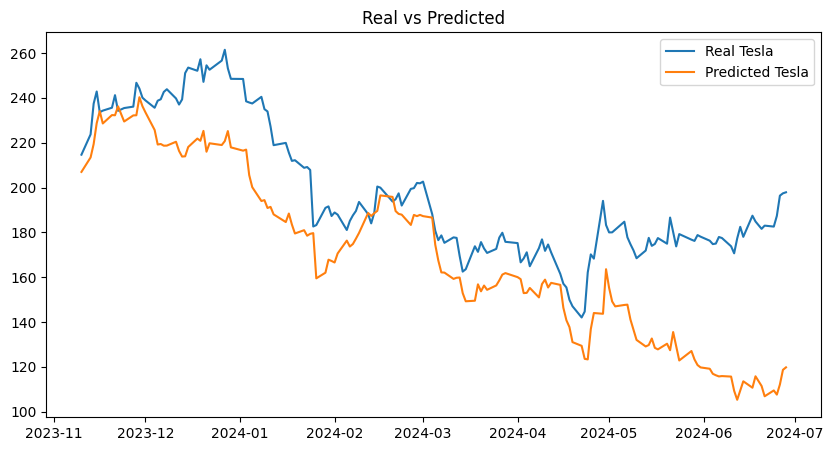

In [23]:
linear_pred_df = pd.Series(linear_pred, index = y_test.index)

fig, ax = plt.subplots(figsize = (10,5))
plt.plot(y_test)
plt.plot(linear_pred_df)
plt.legend(["Real Tesla", "Predicted Tesla"])
plt.title("Real vs Predicted")
plt.show()

Ridge Model MSE: 976.6095714636489
Ridge Model RMSE: 31.250753134343


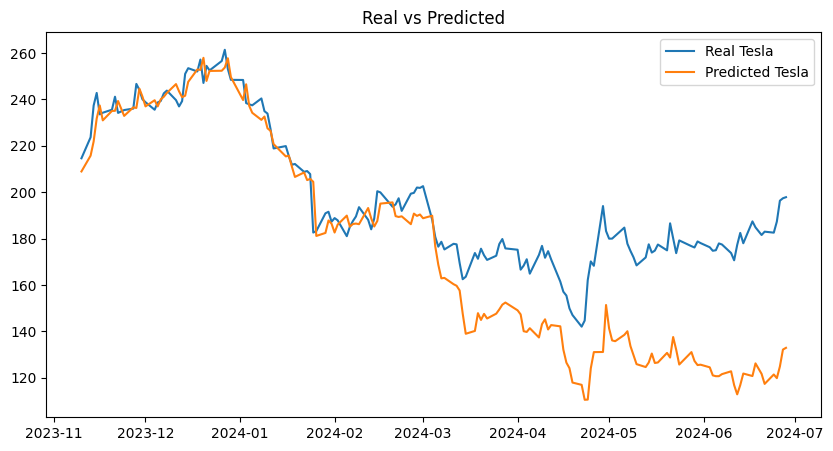

In [24]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

ridge_mse = sum((ridge_pred - y_test) ** 2) / len(y_test)
ridge_rmse = np.sqrt(ridge_mse)
print(f"Ridge Model MSE: {ridge_mse}")
print(f"Ridge Model RMSE: {ridge_rmse}")

ridge_pred_df = pd.Series(ridge_pred, index = y_test.index)

fig, ax = plt.subplots(figsize = (10,5))
plt.plot(y_test)
plt.plot(ridge_pred_df)
plt.legend(["Real Tesla", "Predicted Tesla"])
plt.title("Real vs Predicted")
plt.show()

Lasso Model MSE: 34.3839576076523
Lasso Model RMSE: 5.863783557367402


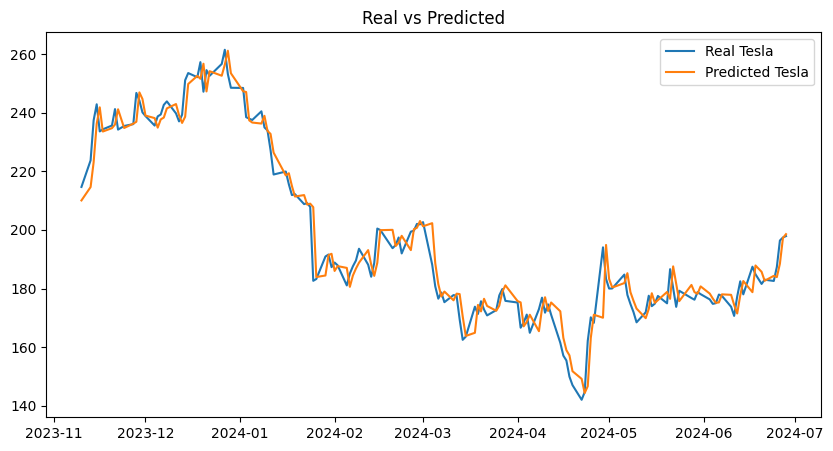

In [25]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

lasso_mse = sum((lasso_pred - y_test) ** 2) / len(y_test)
lasso_rmse = np.sqrt(lasso_mse)
print(f"Lasso Model MSE: {lasso_mse}")
print(f"Lasso Model RMSE: {lasso_rmse}")

lasso_pred_df = pd.Series(lasso_pred, index = y_test.index)

fig, ax = plt.subplots(figsize = (10,5))
plt.plot(y_test)
plt.plot(lasso_pred_df)
plt.legend(["Real Tesla", "Predicted Tesla"])
plt.title("Real vs Predicted")
plt.show()

XGB Model MSE: 215.6950918472153
XGB Model RMSE: 14.686561607374795


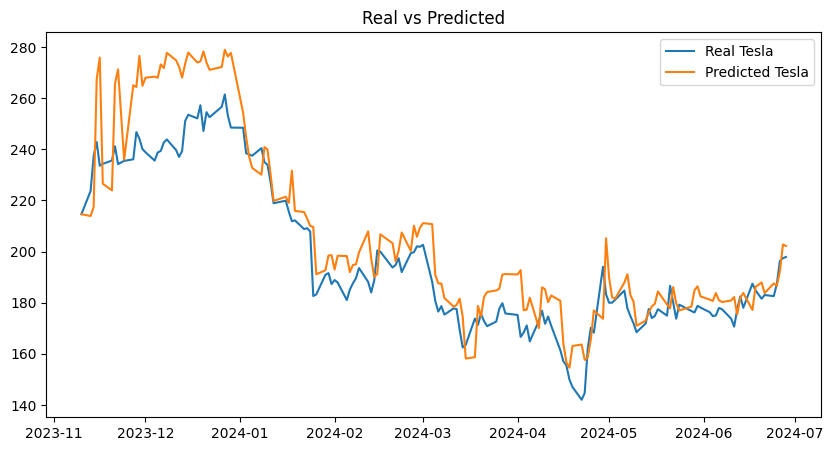

In [26]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

xgb_mse = sum((xgb_pred - y_test) ** 2) / len(y_test)
xgb_rmse = np.sqrt(xgb_mse)
print(f"XGB Model MSE: {xgb_mse}")
print(f"XGB Model RMSE: {xgb_rmse}")

xgb_pred_df = pd.Series(xgb_pred, index = y_test.index)

fig, ax = plt.subplots(figsize = (10,5))
plt.plot(y_test)
plt.plot(xgb_pred_df)
plt.legend(["Real Tesla", "Predicted Tesla"])
plt.title("Real vs Predicted")
plt.show()

In [27]:
lasso_importances = abs(lasso_model.coef_)
ridge_importances = abs(ridge_model.coef_)
linear_importances = abs(linear_model.coef_)
xgb_importances = xgb_model.feature_importances_

# Create DataFrame to compare importances
feature_names = X_train.columns
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Linear': linear_importances,
    'Lasso': lasso_importances,
    'Ridge': ridge_importances,
    'XGBoost': xgb_importances
}).sort_values(by='Lasso', ascending=False)

print(importances_df)

                      Feature      Linear     Lasso      Ridge   XGBoost
4             Tesla_mean_lag1    0.778434  0.930561   0.799097  0.842688
18           Rivian_std_lag30    0.340266  0.149064   0.343408  0.028160
5             Tesla_mean_lag4    0.136845  0.068819   0.118516  0.024871
1                         day    0.246042  0.065014   0.080601  0.000440
6            Tesla_mean_lag30    0.033456  0.036004   0.032242  0.000851
14           Rivian_mean_lag1    0.019461  0.033737   0.006283  0.000501
46      Oil Prices_mean_lag30    0.740505  0.033137   0.265640  0.001535
30   General Motors_mean_lag4    0.310420  0.031459   0.648166  0.000484
2                     weekday    0.518773  0.021718   0.627508  0.000668
33   General Motors_std_lag30    2.050646  0.000000   3.117944  0.000532
41             CCI_mean_lag30   33.160924  0.000000   9.143225  0.000334
35    Interest Rate_mean_lag4    3.004378  0.000000   3.812560  0.004738
36   Interest Rate_mean_lag30    8.682229  0.000000

In [28]:
lasso_importances = lasso_model.coef_

# Create DataFrame for Lasso Model
lasso_feature_names = X_train.columns
lasso_df = pd.DataFrame({
    'Feature': feature_names,
    'Lasso': lasso_importances
}).sort_values(by='Lasso', ascending=False)

print(lasso_df[lasso_df["Lasso"] != 0])

                     Feature     Lasso
4            Tesla_mean_lag1  0.930561
18          Rivian_std_lag30  0.149064
5            Tesla_mean_lag4  0.068819
1                        day  0.065014
14          Rivian_mean_lag1  0.033737
46     Oil Prices_mean_lag30  0.033137
2                    weekday -0.021718
30  General Motors_mean_lag4 -0.031459
6           Tesla_mean_lag30 -0.036004


### RNN Approach

In [29]:
rnn_df = X
rnn_df["Tesla"] = y
rnn_df.head()

,month,day,weekday,year,Tesla_mean_lag1,Tesla_mean_lag4,Tesla_mean_lag30,Tesla_std_lag4,Tesla_std_lag30,Nio_mean_lag1,...,Oil Prices_mean_lag4,Oil Prices_mean_lag30,Oil Prices_std_lag4,Oil Prices_std_lag30,CPI_mean_lag1,CPI_mean_lag4,CPI_mean_lag30,CPI_std_lag4,CPI_std_lag30,Tesla
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-10,11,10,3,2021,235.920944,236.283707,239.762497,6.917064,18.600977,13.457182,...,84.002518,83.991913,1.676590,3.906139,5.554287,5.562372,5.628571,0.080226,0.538754,355.983337
2021-11-11,11,11,4,2021,355.983337,355.983337,355.983337,6.917064,18.600977,39.549999,...,81.339996,81.339996,1.676590,3.906139,5.921978,5.921978,5.921978,0.080226,0.538754,354.503326
2021-11-12,11,12,5,2021,354.503326,355.243347,355.243347,1.046526,1.046526,42.200001,...,81.464996,81.464996,0.176777,0.176777,5.921978,5.921978,5.921978,0.000000,0.000000,344.473328
2021-11-15,11,15,1,2021,344.473328,351.653320,351.653320,6.261944,6.261944,42.669998,...,81.239998,81.239998,0.409268,0.409268,5.921978,5.921978,5.921978,0.000000,0.000000,337.796661
2021-11-16,11,16,2,2021,337.796661,348.189148,348.189148,8.610640,8.610640,40.570000,...,81.150002,81.150002,0.379561,0.379561,5.921978,5.921978,5.921978,0.000000,0.000000,351.576660


In [30]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(rnn_df)

In [31]:
def create_sequences(data, n_timesteps):
    X, y = [], []
    for i in range(n_timesteps, len(data)):
        X.append(data[i-n_timesteps:i])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

n_timesteps = 30
X, y = create_sequences(scaled_df, n_timesteps)

In [32]:
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [34]:
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (n_timesteps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

In [35]:
model.compile(optimizer='adam', loss='mse')

In [36]:
history = model.fit(X_train, y_train, epochs = 200, batch_size = 72, validation_data=  (X_test, y_test), verbose = 2)

Epoch 1/200
7/7 - 11s - loss: 0.0902 - val_loss: 0.0096 - 11s/epoch - 2s/step
Epoch 2/200
7/7 - 0s - loss: 0.0329 - val_loss: 0.0097 - 360ms/epoch - 51ms/step
Epoch 3/200
7/7 - 0s - loss: 0.0226 - val_loss: 0.0130 - 366ms/epoch - 52ms/step
Epoch 4/200
7/7 - 0s - loss: 0.0180 - val_loss: 0.0099 - 367ms/epoch - 52ms/step
Epoch 5/200
7/7 - 1s - loss: 0.0176 - val_loss: 0.0151 - 734ms/epoch - 105ms/step
Epoch 6/200
7/7 - 1s - loss: 0.0169 - val_loss: 0.0128 - 745ms/epoch - 106ms/step
Epoch 7/200
7/7 - 0s - loss: 0.0136 - val_loss: 0.0123 - 360ms/epoch - 51ms/step
Epoch 8/200
7/7 - 0s - loss: 0.0129 - val_loss: 0.0115 - 366ms/epoch - 52ms/step
Epoch 9/200
7/7 - 0s - loss: 0.0099 - val_loss: 0.0142 - 365ms/epoch - 52ms/step
Epoch 10/200
7/7 - 0s - loss: 0.0086 - val_loss: 0.0171 - 381ms/epoch - 54ms/step
Epoch 11/200
7/7 - 1s - loss: 0.0083 - val_loss: 0.0167 - 815ms/epoch - 116ms/step
Epoch 12/200
7/7 - 1s - loss: 0.0073 - val_loss: 0.0151 - 824ms/epoch - 118ms/step
Epoch 13/200
7/7 - 1s - 

In [37]:
y_pred = model.predict(X_test)

6/6 [==============================] - 4s 34ms/step


In [38]:
y_pred_unscaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], n_features - 1))), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], n_features - 1))), axis=1))[:, 0]

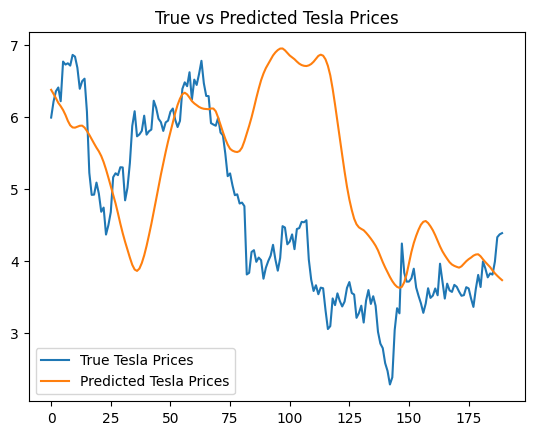

In [39]:
plt.plot(y_test_unscaled, label='True Tesla Prices')
plt.plot(y_pred_unscaled, label='Predicted Tesla Prices')
plt.legend()
plt.title('True vs Predicted Tesla Prices')
plt.show()